# Proyecto: Predicción de Alzheimer a partir de MRI usando Deep Learning




## **0. Integrantes del equipo de trabajo**
---
1. RAÚL RAMÍREZ PENAGOS
2. IVÁN QUEVEDO
3. LINA ÁVILA MORENO

## **1. Entendimiento de los datos**

El conjunto de datos contiene 4 clases y etiquetas del 0 al 3:

1. Non demented : '0'
2. Very midly demented : '1'
3. Mildly demented : '2'
4. Moderately demented : '3'

In [ ]:
#pip install opencv-python
#!pip install tensorflow

In [ ]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import hashlib
import matplotlib.cm as cm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import random
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau



In [ ]:
#!pip install pyarrow

In [ ]:
# Ejecución local
local_path = "~/Downloads/diplomado/mlds3"
df_train = pd.read_parquet(f"{local_path}/train.parquet")
df_test = pd.read_parquet(f"{local_path}/test.parquet")

In [ ]:
df_train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [ ]:
df_test.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1280 non-null   object
 1   label   1280 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.1+ KB


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5120 non-null   object
 1   label   5120 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.1+ KB


In [ ]:
# Ejecución local
dest_dir = f"{local_path}/procesado"
os.makedirs(dest_dir, exist_ok=True)

In [ ]:
etiqueta_enfermedad_categoria = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

In [ ]:
def decodificar_imagen(image_dict):
    if isinstance(image_dict, dict) and "bytes" in image_dict:
        byte_string = image_dict["bytes"]
        datos_raw_np = np.frombuffer(byte_string, np.uint8)

        # Cargar en escala de grises (1 canal)
        img = cv2.imdecode(datos_raw_np, cv2.IMREAD_GRAYSCALE)

        # Redimensionar
        img = cv2.resize(img, (224, 224))

        # Expandir a 3 canales se replicó la imagen en gris
        img_3ch = np.stack([img, img, img], axis=-1)

        return img_3ch

    else:
        raise TypeError(f"Se esperaba un diccionario {type(image_dict)}")

In [ ]:
#Verifico que tenga los 3 canales
img_dict = df_train["image"].iloc[0]
img_3ch = decodificar_imagen(img_dict)
print(img_3ch.shape)

(224, 224, 3)


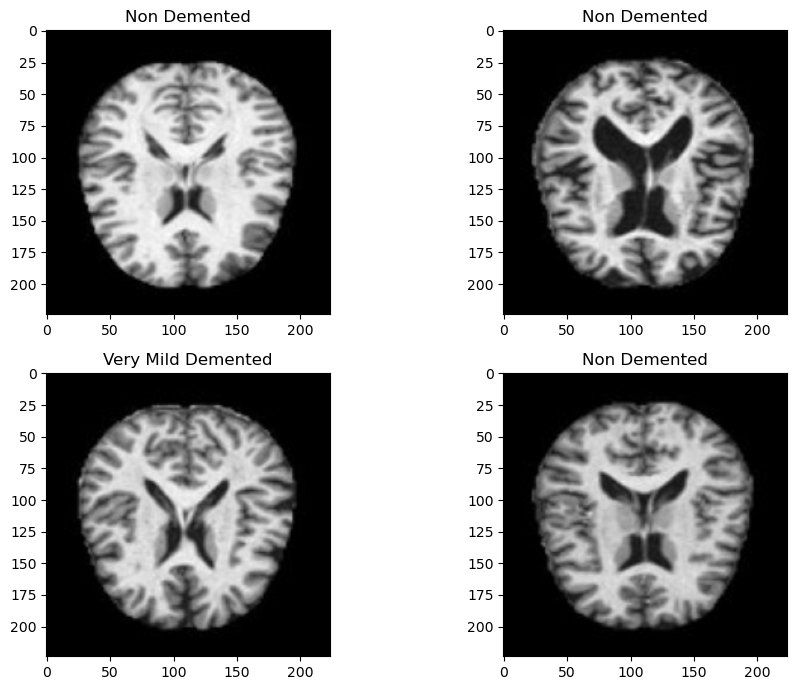

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
axs = ax.flatten()
for axes in axs:
    rand = np.random.randint(0, len(df_train))
    decoded_image = decodificar_imagen(df_train.iloc[rand]['image'])
    axes.imshow(decoded_image, cmap="gray")
    axes.set_title(etiqueta_enfermedad_categoria[df_train.iloc[rand]['label']])
plt.tight_layout()
plt.show()

In [ ]:
#Valores Faltantes
print(df_train.isnull().sum())

image    0
label    0
dtype: int64


In [ ]:
#Valores Faltantes
print(df_test.isnull().sum())

image    0
label    0
dtype: int64


## **2. Limpieza de los datos**

In [ ]:
#Imágenes corruptas

df_train['img_arr'] = df_train['image'].apply(decodificar_imagen)
df_test['img_arr'] = df_test['image'].apply(decodificar_imagen)


def imagen_valida(img_array):
    return img_array is not None and img_array.size > 0


In [ ]:
# Aplicar validación de imágenes corruptas en df_train
init_train = len(df_train)
df_train = df_train[df_train["img_arr"].apply(imagen_valida)]
cleaned_train = len(df_train)
print(f"Filas de entrenamiento antes de limpiar: {init_train}")
print(f"Filas de entrenamiento después de limpiar: {cleaned_train}")
print(f"Filas de entrenamiento eliminadas: {init_train - cleaned_train}")

Filas de entrenamiento antes de limpiar: 5120
Filas de entrenamiento después de limpiar: 5120
Filas de entrenamiento eliminadas: 0


In [ ]:
# Aplicar validación de imágenes corruptas en df_test
init_test = len(df_test)
df_test = df_test[df_test["img_arr"].apply(imagen_valida)]
cleaned_test = len(df_test)
print(f"Filas de prueba antes de limpiar: {init_test}")
print(f"Filas de prueba después de limpiar: {cleaned_test}")
print(f"Filas de prueba eliminadas: {init_test - cleaned_test}")

Filas de prueba antes de limpiar: 1280
Filas de prueba después de limpiar: 1280
Filas de prueba eliminadas: 0


In [ ]:
#Duplicados

def hash_image(img):
    return hashlib.md5(img.tobytes()).hexdigest()

df_train["hash"] = df_train["img_arr"].apply(hash_image)
df_test["hash"] = df_test["img_arr"].apply(hash_image)

duplicados = df_train.duplicated(subset="hash").sum()
print("Número de imágenes duplicadas en train:", duplicados)

duplicados_test = df_test.duplicated(subset="hash").sum()
print("Número de imágenes duplicadas en test:", duplicados_test)

Número de imágenes duplicadas en train: 0
Número de imágenes duplicadas en test: 0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    5120 non-null   object
 1   label    5120 non-null   int64 
 2   img_arr  5120 non-null   object
 3   hash     5120 non-null   object
dtypes: int64(1), object(3)
memory usage: 160.1+ KB


In [ ]:
#Elimino la columna hash creada previamente
df_train = df_train.drop(columns="hash")
df_test = df_test.drop(columns="hash")

In [ ]:
#df_train.info()

In [ ]:
#Balanceo de clases
df_train["label"].value_counts()

label
2    2566
3    1781
0     724
1      49
Name: count, dtype: int64

/var/folders/zn/tn1w_nlx1b1cz5h81x332dfw0000gn/T/ipykernel_5956/1021562858.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', num_classes)


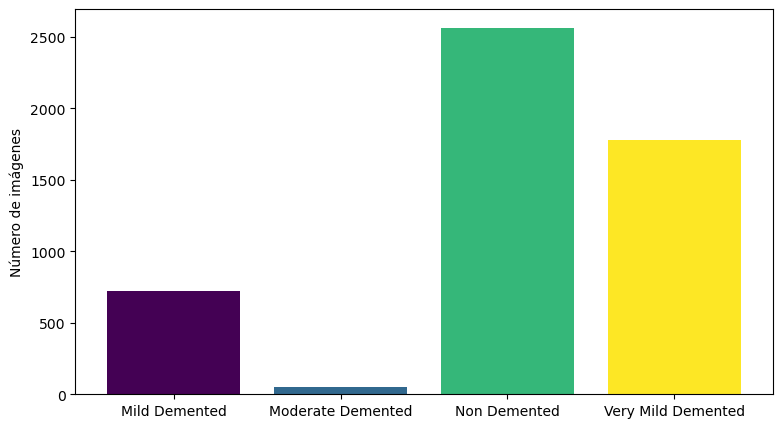

Total muestras en train = 5120


In [ ]:
plt.figure(figsize=(9, 5))
num_classes = df_train['label'].nunique()
colors = cm.get_cmap('viridis', num_classes)
plt.bar(np.arange(0, 4, 1), df_train['label'].value_counts().sort_index(), color=[colors(i) for i in range(num_classes)])
plt.ylabel("Número de imágenes")
plt.xticks(np.arange(0, 4, 1), labels=[etiqueta_enfermedad_categoria[i] for i in range(4)])
plt.show()
print(f"Total muestras en train = {len(df_train)}")

In [ ]:
df_train.head()

,image,label,img_arr
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


## **3. Relaciones entre variables**

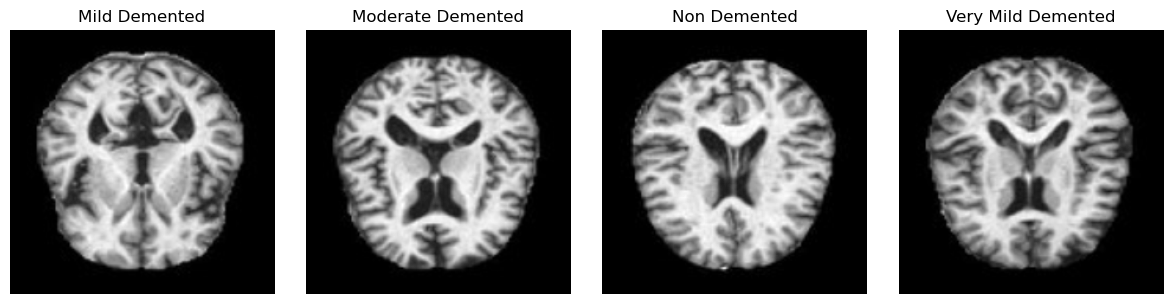

In [ ]:
#Imágenes por clase
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
classes = [0, 1, 2, 3]

for i, c in enumerate(classes):
    img = df_train[df_train.label==c]["img_arr"].values[0]
    ax = axes[i]
    ax.imshow(img[:,:,0], cmap='gray')
    ax.set_title(etiqueta_enfermedad_categoria[c])
    ax.axis('off')

plt.tight_layout()
plt.show()


<Axes: xlabel='label', ylabel='mean_pixel'>

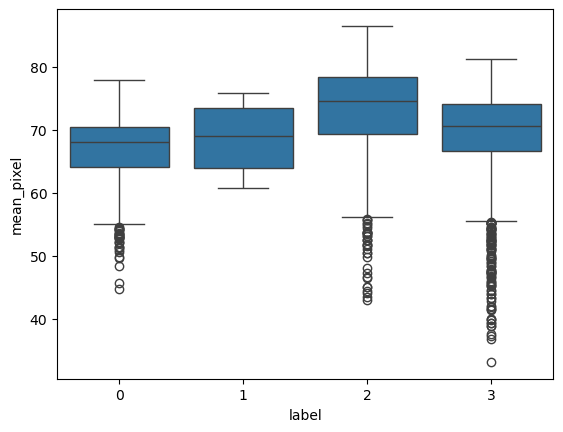

In [ ]:
#Resumen estadístico por clase
df_train['mean_pixel'] = df_train['img_arr'].apply(lambda x: x.mean())
df_train['std_pixel']  = df_train['img_arr'].apply(lambda x: x.std())
sns.boxplot(x='label', y='mean_pixel', data=df_train)

In [ ]:
df_train.groupby('label')['mean_pixel'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,724.0,66.787180,5.329057,44.750080,64.157770,68.063357,70.407834,77.865374
1,49.0,68.919287,5.023120,60.755082,64.019491,68.945890,73.394053,75.885523
2,2566.0,73.529434,6.620926,43.005979,69.375259,74.605200,78.376564,86.486966
3,1781.0,69.302542,7.126667,33.168806,66.606565,70.593132,74.088508,81.304807


### **3.1. Análisis de componentes

---

principales PCA**

Aplicaremos a continuación un Análisis de Componentes Principales (PCA) sobre las imágenes de resonancia magnética ya preprocesadas. Cada imagen se reescala a una resolución de 224×224 píxeles y se representa con 3 canales, lo que da lugar a un total de 150 528 características por imagen (224×224×3). Posteriormente, cada imagen se aplana en un vector de esa longitud, construyendo así la matriz X_train_flat, donde cada fila corresponde a una imagen y cada columna a un píxel específico.

In [ ]:
X_train_flat = np.array([img_array.flatten() for img_array in df_train['img_arr']])
print("X_train_flat:", X_train_flat.shape)
print("Los primeros 5 elementos de la primera imagen aplanada:", X_train_flat[0, :5])

X_train_flat: (5120, 150528)
Los primeros 5 elementos de la primera imagen aplanada: [0 0 0 0 0]


In [ ]:
pca = PCA(n_components=200, svd_solver='randomized')
pca.fit(X_train_flat)

PCA(n_components=200, svd_solver='randomized')

Para seleccionar adecuadamente el número óptimo de componentes en un análisis PCA, evaluaremos cómo se distribuye la varianza explicada entre los componentes principales.


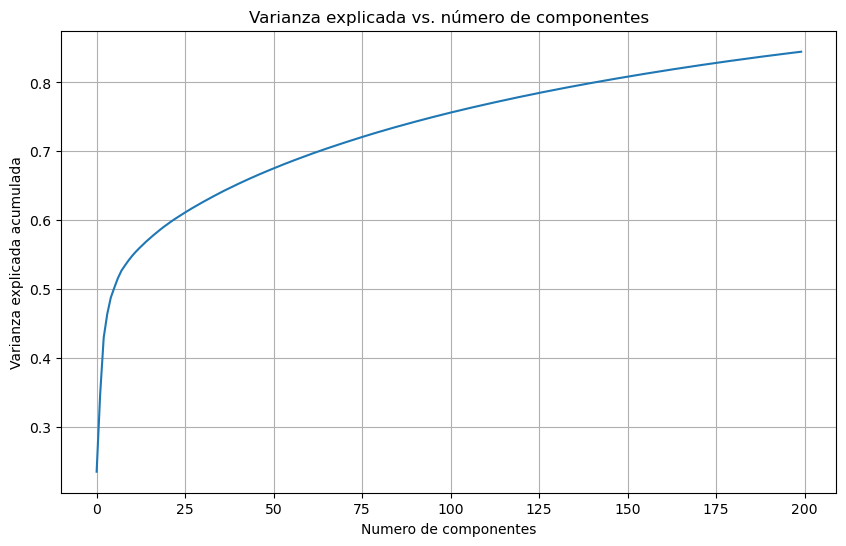

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Numero de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada vs. número de componentes')
plt.grid(True)
plt.show()

La gráfica de varianza explicada acumulada del PCA aplicado muestra que las primeras componentes concentran casi toda la información: con las primeras centenas de componentes ya se supera alrededor del 90–95 % de la varianza y, a partir de ahí, la curva se vuelve casi horizontal, indicando que añadir más componentes aporta muy poco.

Esto significa que, aunque cada imagen tiene miles de píxeles, la estructura relevante del conjunto de datos vive en un espacio de dimensión mucho menor.

En la práctica, el PCA nos permite comprimir las imágenes de Alzheimer en un número reducido de componentes sin perder casi información.

Se entrena un segundo PCA fijando n_components=2. Con este modelo se proyectan las imágenes al plano definido por las dos primeras componentes principales, generando así una representación bidimensional (X_train_pca).

In [ ]:
pca_2d = PCA(n_components=2)
X_train_pca = pca_2d.fit_transform(X_train_flat)
print("Forma de los datos transformados mediante PCA:", X_train_pca.shape)


Forma de los datos transformados mediante PCA: (5120, 2)


Esta proyección se grafica en un diagrama de dispersión donde cada punto corresponde a una imagen y el color indica la clase de demencia (label).

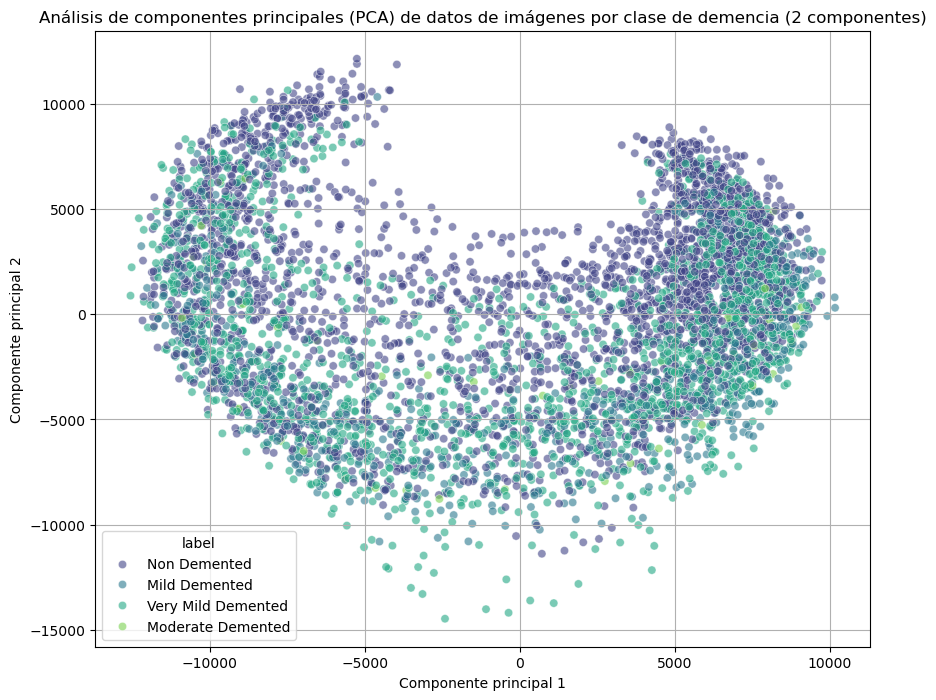

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_train_pca[:, 0],
    y=X_train_pca[:, 1],
    hue=df_train['label'].map(etiqueta_enfermedad_categoria),
    palette='viridis',
    legend='full',
    alpha=0.6
)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Análisis de componentes principales (PCA) de datos de imágenes por clase de demencia (2 componentes)')
plt.grid(True)
plt.show()

Este tipo de visualización permite:

* Observar si existen agrupamientos naturales de las imágenes en el espacio de las primeras componentes.

* Valorar de forma cualitativa si las clases muestran alguna tendencia a separarse o si se solapan fuertemente cuando resumimos la información a solo dos dimensiones.

## **4. Modelo**

In [ ]:
def oversample(X, y):
    X_bal = list(X)
    y_bal = list(y)

    values, counts = np.unique(y, return_counts=True)
    max_count = counts.max()

    for cls, count in zip(values, counts):
        if count < max_count:
            deficit = max_count - count
            indices = np.where(y == cls)[0]
            sampled_idx = np.random.choice(indices, deficit, replace=True)

            X_bal.extend(X[sampled_idx])
            y_bal.extend(y[sampled_idx])

    return np.array(X_bal), np.array(y_bal)

X = np.stack(df_train['img_arr'].values)
y = df_train['label'].values

X_bal, y_bal = oversample(X, y)

print("Dataset balanceado:", np.bincount(y_bal))


Dataset balanceado: [2566 2566 2566 2566]


In [ ]:
#Partición del conjunto de datos

X_train, X_temp, y_train, y_temp = train_test_split(
    X_bal, y_bal, test_size=0.25, stratify=y_bal, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(np.bincount(y_train), np.bincount(y_val), np.bincount(y_test))

[1924 1925 1924 1925] [321 320 321 321] [321 321 321 320]


In [ ]:
train_datagen = ImageDataGenerator(
    zoom_range=0.02,
    rotation_range=2,
    brightness_range=[0.9, 1.1],
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

batch_size = 32

train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
val_gen   = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)


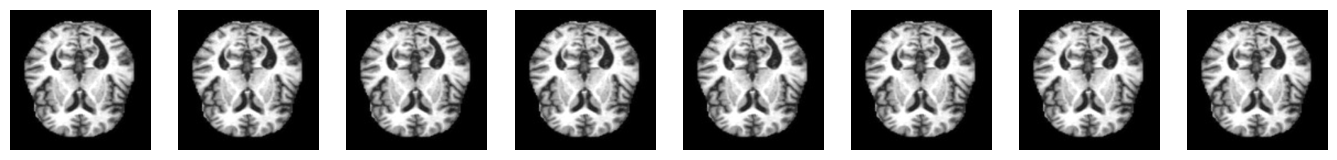

In [ ]:
def normalize_mri_for_display(img):
    p2, p98 = np.percentile(img, (2, 98))
    img = np.clip(img, p2, p98)
    img = (img - img.min()) / (img.max() - img.min() + 1e-10)
    return img
random_index = random.randint(0, len(df_train) - 1)

image_data = df_train.loc[random_index, 'img_arr']  # (H,W,1)

x = image_data.reshape((1,) + image_data.shape)

fig, axs = plt.subplots(1, 8, figsize=(17, 4))

i = 0
for batch in ImageDataGenerator().flow(x, batch_size=1):
    img = batch[0][:,:,0]

    # ⚡ Normalizamos SOLO para visualización
    img_norm = normalize_mri_for_display(img)

    axs[i].imshow(img_norm, cmap='gray')
    axs[i].axis('off')

    i += 1
    if i == 8:
        break

plt.show()



In [ ]:
#verificando dimensiones
print(df_train['img_arr'].iloc[0].shape)


(224, 224, 3)


In [ ]:
unique, counts = np.unique(y_bal, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2566, 1: 2566, 2: 2566, 3: 2566}


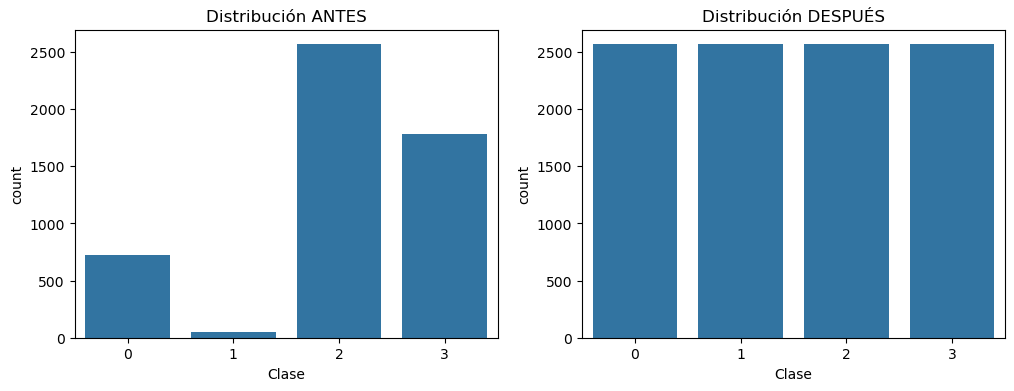

In [ ]:
# Dataframes para graficar
df_before = pd.DataFrame({"Clase": y})
df_after  = pd.DataFrame({"Clase": y_bal})

fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.countplot(data=df_before, x="Clase", ax=ax[0])
ax[0].set_title("Distribución ANTES")

sns.countplot(data=df_after, x="Clase", ax=ax[1])
ax[1].set_title("Distribución DESPUÉS")

plt.show()

In [ ]:
#Generadores

from tensorflow.keras.applications.vgg16 import preprocess_input

# Generador de entrenamiento
train_datagen = ImageDataGenerator(
    zoom_range=0.02,
    rotation_range=2,
    brightness_range=[0.9, 1.1],
    preprocessing_function=preprocess_input
)

# Generador validación
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [ ]:
batch_size = 32

train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
val_gen   = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

input_shape = (224, 224, 3)
num_classes = 4

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


2025-12-04 17:12:22.969596: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-04 17:12:22.970526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M3 Pro


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

ruta_pesos = "pesos_del_modelo.weights.h5"

checkpoint = ModelCheckpoint(
    filepath=ruta_pesos,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

plateau = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5
)


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12,
    callbacks=[checkpoint, plateau],
    verbose=1
)


Epoch 1/12


2025-12-04 17:12:59.707200: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-12-04 17:13:00.287677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 [==============================] - ETA: 0s - loss: 1.2005 - accuracy: 0.5444

2025-12-04 17:13:45.115148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.78668, saving model to pesos_del_modelo.weights.h5
241/241 [==============================] - 48s 191ms/step - loss: 1.2005 - accuracy: 0.5444 - val_loss: 0.7867 - val_accuracy: 0.7467 - lr: 1.0000e-04
Epoch 2/12
241/241 [==============================] - ETA: 0s - loss: 0.7042 - accuracy: 0.6877
Epoch 2: val_loss improved from 0.78668 to 0.55760, saving model to pesos_del_modelo.weights.h5
241/241 [==============================] - 44s 181ms/step - loss: 0.7042 - accuracy: 0.6877 - val_loss: 0.5576 - val_accuracy: 0.7786 - lr: 1.0000e-04
Epoch 3/12
241/241 [==============================] - ETA: 0s - loss: 0.5745 - accuracy: 0.7407
Epoch 3: val_loss improved from 0.55760 to 0.48945, saving model to pesos_del_modelo.weights.h5
241/241 [==============================] - 44s 181ms/step - loss: 0.5745 - accuracy: 0.7407 - val_loss: 0.4895 - val_accuracy: 0.7927 - lr: 1.0000e-04
Epoch 4/12
241/241 [==============================] - ETA: 0s - loss: 

In [ ]:
#evaluación contra test
test_gen = val_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

test_loss, test_acc = model.evaluate(test_gen)
print("Accuracy en test:", test_acc)


41/41 [==============================] - 2s 53ms/step - loss: 0.0704 - accuracy: 0.9680
Accuracy en test: 0.9680436253547668


In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

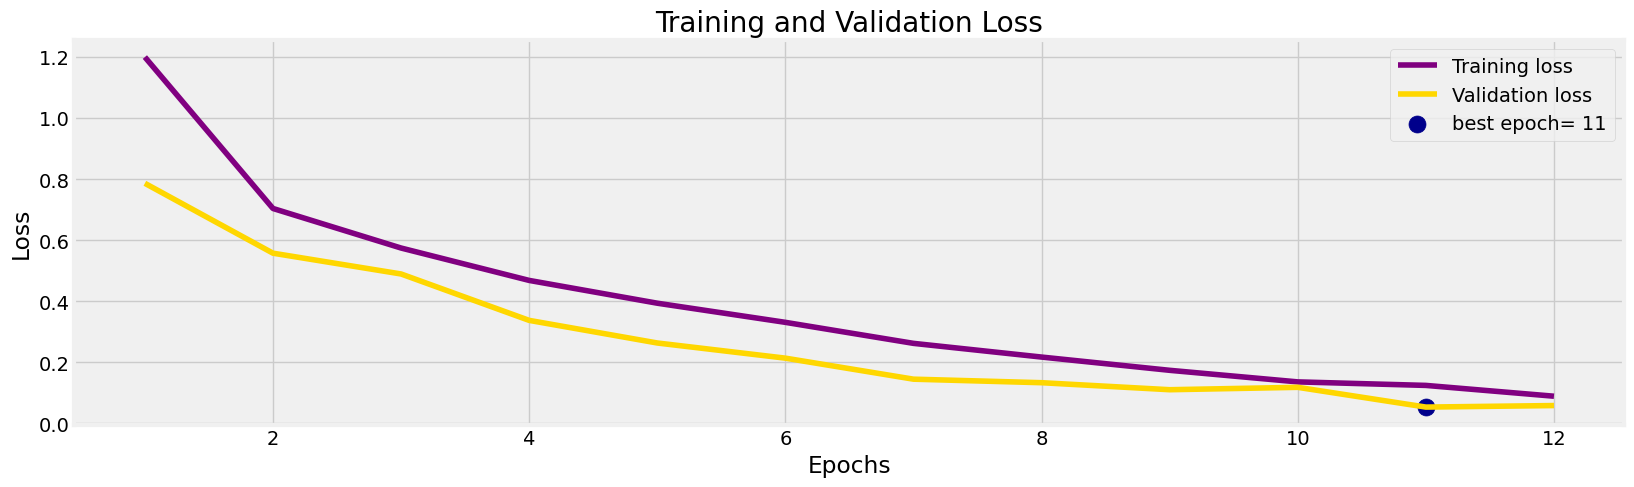

In [ ]:
plt.figure(figsize= (20, 5))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_loss, 'purple', label= 'Training loss')
plt.plot(Epochs, val_loss, 'gold', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout
plt.show()

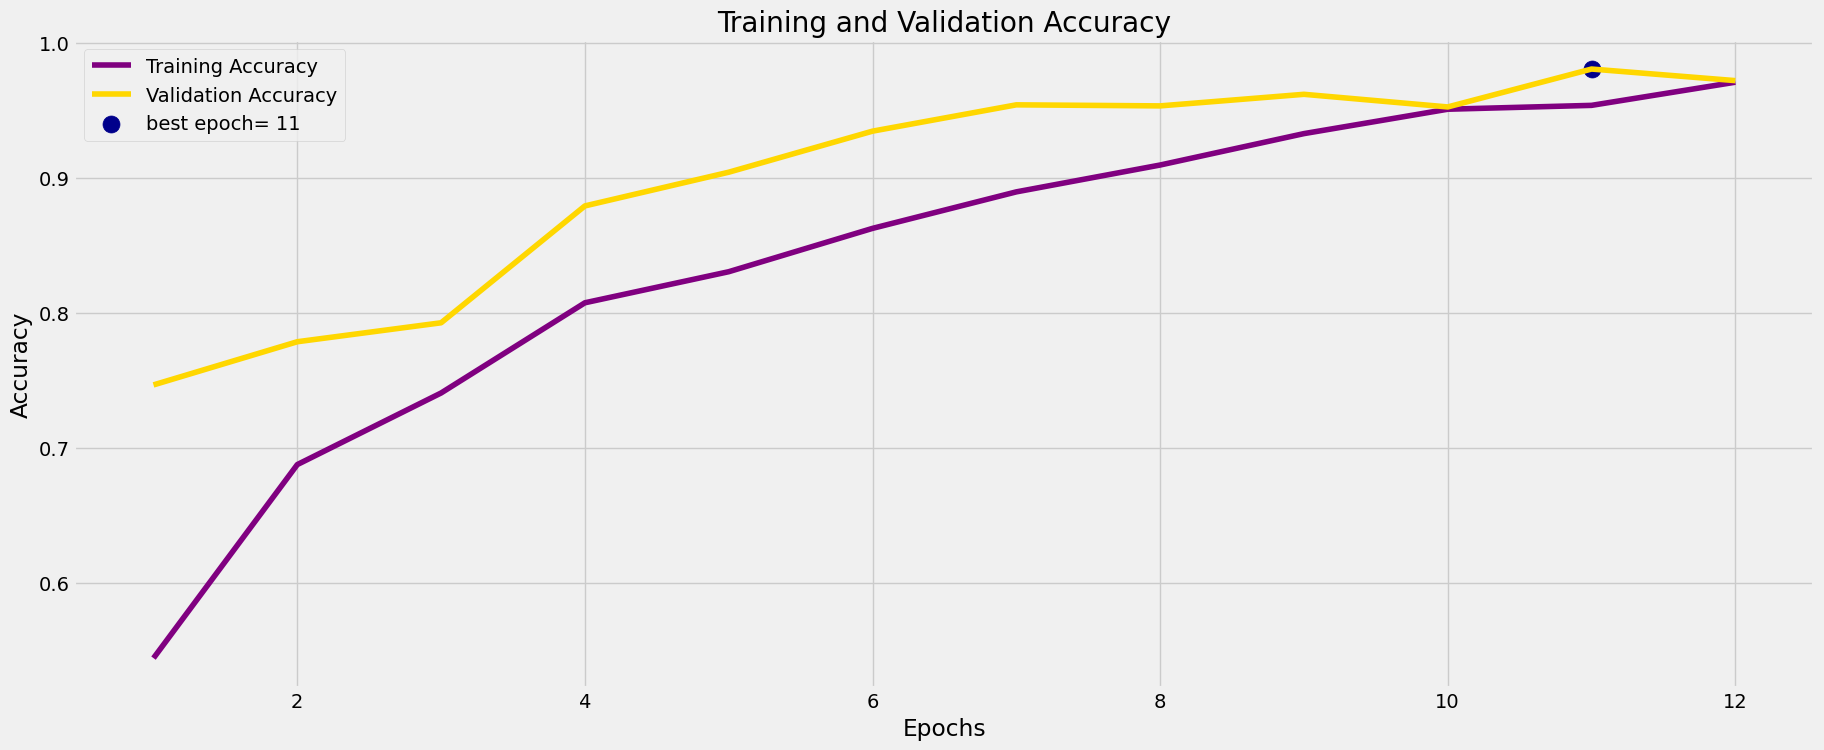

In [ ]:
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_acc, 'purple', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'gold', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
y_pred_prob = model.predict(val_gen)
y_pred = np.argmax(y_pred_prob, axis=1)


 2/41 [>.............................] - ETA: 2s

2025-12-04 17:31:03.201942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 45ms/step


<Figure size 800x600 with 0 Axes>

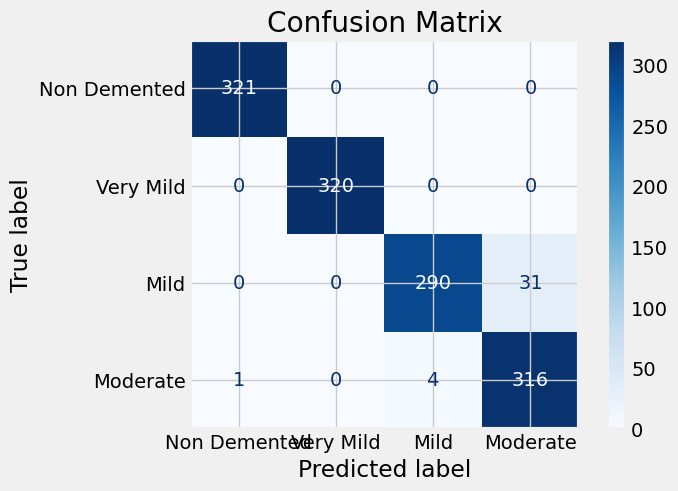

              precision    recall  f1-score   support

Non Demented       1.00      1.00      1.00       321
   Very Mild       1.00      1.00      1.00       320
        Mild       0.99      0.90      0.94       321
    Moderate       0.91      0.98      0.95       321

    accuracy                           0.97      1283
   macro avg       0.97      0.97      0.97      1283
weighted avg       0.97      0.97      0.97      1283



In [ ]:
y_true = val_gen.y
# 3. Matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_labels = ["Non Demented", "Very Mild", "Mild", "Moderate"]

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

#Reporte de clasificación
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_labels))

41/41 [==============================] - 2s 50ms/step


<Figure size 800x600 with 0 Axes>

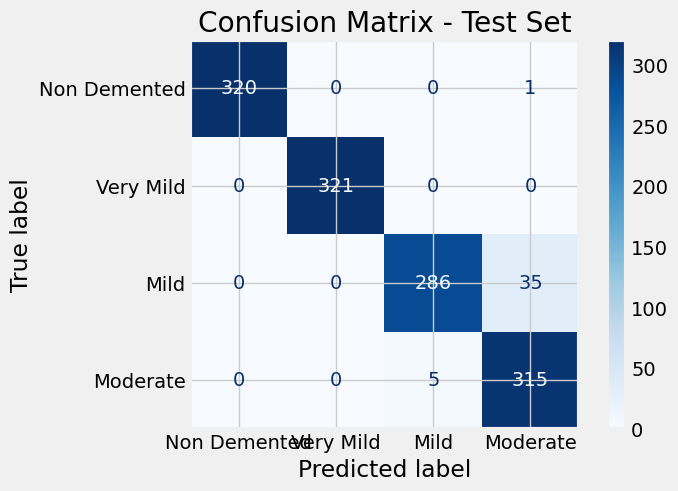

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
test_gen = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

y_test_true = test_gen.y
y_test_pred = np.argmax(model.predict(test_gen), axis=1)

# Predicciones
y_test_pred_prob = model.predict(test_gen)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Ver etiquetas reales
y_test_true = test_gen.y

# Etiquetas legibles
class_labels = ["Non Demented", "Very Mild", "Mild", "Moderate"]

# Matriz
cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
# 1. Obtener y verdaderos
y_test_true = test_gen.y  # etiquetas reales desde el generador

# 2. Obtener predicciones del modelo
y_test_pred_probs = model.predict(test_gen)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# 3. Mostrar reporte
print(classification_report(y_test_true, y_test_pred))

41/41 [==============================] - 2s 49ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       321
           1       1.00      1.00      1.00       321
           2       0.98      0.89      0.93       321
           3       0.90      0.98      0.94       320

    accuracy                           0.97      1283
   macro avg       0.97      0.97      0.97      1283
weighted avg       0.97      0.97      0.97      1283

